In [1]:
%pip install torchmetrics --quiet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import torchmetrics
from torchvision import transforms as T
import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

In this notebook we show the implementation of the "adversarial free training"  (https://arxiv.org/pdf/1904.12843.pdf), an algorithm that has the objective to train a model against adversarial examples without involving the big overhead that a task like this usually implies. In fact it is well known that generate adversarial example is an expensive task, but the key point of this algorithm aims to handle it by recycling the gradient information computed when updating model paramaters and generate adversarial examples with this information. Indeed, making the numbers speak, the training time of the model with the "adversarial free training" and with the classic training is about the same.
To test the free-algorithm we have use the PGD-K attack for generating adversarial datasets. PGD-K is a simple variant of the FGSM method (https://pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/) that, given a sample x, generate an adversarial example $x_{adv}$ in this way:
$x_{adv} = x+ \epsilon*sign(\nabla_x(l(x,y,ϴ))$.


PGD-K is an iterativate version of FGSM (k iterations) with a uniroform random noise as attacks.






In order to make our experiments coerent we have always worked on the same gpu to train the model, a **Tesla T4 (UUID: GPU-c5501dbc-32d1-e97b-3398-84328677c15c)**

In [3]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9e6c8fe7-b521-a730-e0f7-90d25ef9374f)


GPU 0: Tesla T4 (UUID: GPU-c5501dbc-32d1-e97b-3398-84328677c15c)
# TODO: describe why we want use for all tests always the same GPU

As dataset for training and test we have used CIFAR10, a collection of 60.000 32x32x8 images with 10 classes of classification. We have also applied some transformations on it in order to do some data augmentation. 

In [4]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = T.Compose([
        T.RandomRotation(15),
        T.RandomHorizontalFlip(),
        T.ToTensor()
])

batch_size = 64

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=T.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**TODO:** explain the model

In [7]:
# From https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/resnet.py

import torch.nn.init as init
from torch.autograd import Variable

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)

def cfg(depth):
    depth_lst = [18, 34, 50, 101, 152]
    assert (depth in depth_lst), "Error : Resnet depth should be either 18, 34, 50, 101, 152"
    cf_dict = {
        '18': (BasicBlock, [2,2,2,2]),
        '34': (BasicBlock, [3,4,6,3]),
        '50': (Bottleneck, [3,4,6,3]),
        '101':(Bottleneck, [3,4,23,3]),
        '152':(Bottleneck, [3,8,36,3]),
    }

    return cf_dict[str(depth)]

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 16

        block, num_blocks = cfg(depth)

        self.conv1 = conv3x3(3,16)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
def create_model():
  return ResNet(18, 10).to(device)

Training each version of the model takes a while, so we store trained models on github. The following code blocks define functions for loading and saving models.

To store the trained models have implemented a mechanism combining torch.save() and a git repository. In particular with the function save_model() we store the model in local and then with load_model() we are able to recover it already trained.

In [7]:
! rm -rf repo && git clone https://github.com/dp1/adversarial-training-for-free repo

Cloning into 'repo'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 48 (delta 6), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (48/48), 6.98 MiB | 4.27 MiB/s, done.


In [8]:
def save_model(name, model, training_metadata):
  torch.save({
      'metadata': training_metadata,
      'weights': model.state_dict()
  }, f'{name}.pth')

def load_model(name):
  data = torch.load(f'repo/models/{name}.pth')
  model = create_model()
  model.load_state_dict(data['weights'])
  return (model, data['metadata'])

In [9]:
def accuracy(net, loader, device):
  acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = net(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [ ]:
#model = create_model()
#accuracy(model, test_loader, device)

**Classic training algorithm**

In [10]:
def train_model(model, epochs=60):
  start_time = datetime.now()
  epoch_accuracies = []

  loss = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    model.train()
    for xb, yb in tqdm.tqdm(train_loader):
      
      xb, yb = xb.to(device), yb.to(device)

      opt.zero_grad()
      ypred = model(xb)
      l = loss(ypred, yb)
      l.backward()
      opt.step()

    model.eval()
    epoch_accuracies.append(float(accuracy(model, test_loader, device)))
    print(f'Accuracy at epoch {epoch}: {epoch_accuracies[-1]}')
  
  training_time = datetime.now() - start_time
  print(f'Training took {training_time}')

  return {
      'training_seconds': round(training_time.total_seconds()),
      'epoch_accuracies': epoch_accuracies
  }

In [ ]:
#training_metadata = train_model(model, epochs=60)

In [ ]:
#save_model('resnet-natural', model, training_metadata)

In [11]:
%pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**PGD-k attack implementation**

In [12]:
import torchattacks

In [13]:
def test_pgd_attack(model, k=20):
  atk = torchattacks.PGD(model, steps=k)
  adversarial = [[atk(test_x, test_y), test_y] for test_x, test_y in test_loader]
  
  acc_normal = float(accuracy(model, test_loader, device))
  acc_adversarial = float(accuracy(model, adversarial, device))
  
  print(f'Accuracy on normal dataset: {acc_normal}')
  print(f'Accuracy on adversarial samples: {acc_adversarial}')
  return acc_normal, acc_adversarial

In [ ]:
#test_pgd_attack(model, k=5)

**TODO:** explain the free_training

In [14]:
from torch.autograd import Variable

def free_training(model, epochs=60, m=1, eps=8/255):
  start_time = datetime.now()
  epoch_accuracies = []

  loss = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters())

  d = torch.zeros([batch_size, 3, 32, 32]).to(device)

  for epoch in range(epochs // m):

    model.train()
    for xb, yb in tqdm.tqdm(train_loader):
      xb, yb = xb.to(device), yb.to(device)
      
      for _ in range(m):

        cur_batch_size = xb.shape[0]
        delta = Variable(d[:cur_batch_size], requires_grad=True)
        x_adv = xb + delta

        opt.zero_grad()
        ypred = model(x_adv)
        l = loss(ypred, yb)
        l.backward()

        pert = torch.sign(delta.grad) * eps
        d[:cur_batch_size] += pert.data
        d.clamp_(-eps, eps)
        
        opt.step()

    model.eval()
    epoch_accuracies.append(float(accuracy(model, test_loader, device)))
    print(f'Accuracy at epoch {epoch}: {epoch_accuracies[-1]}')
    
  training_time = datetime.now() - start_time
  print(f'Training took {training_time}')

  return {
      'training_seconds': round(training_time.total_seconds()),
      'epoch_accuracies': epoch_accuracies
  }

In [ ]:
#print(batch_size)

In [ ]:
#for m in [1,2,4,6,10,15,30,60]:
  #model_adv = create_model()
  #training_metadata = free_training(model_adv, epochs=60, m=m, eps=8/255)
  #print(training_metadata)
  #save_model(f'resnet-m={m}', model_adv, training_metadata)


In [15]:
import json
def save_data(name, metadata):
  with open(f'{name}.json', "w") as fout:
    json.dump(metadata, fout)

def load_data(name):
  with open(f'repo/models/{name}.json') as fin:
    data = json.load(fin)
    return data

**SAVE ACCURACIES AND TRAINING_TIME OF EACH MODEL**

In [21]:
model, meta = load_model("resnet-natural")
acc_normal, acc_adv20 = test_pgd_attack(model, k=20)
acc_normal, acc_adv100 = test_pgd_attack(model, k=100)
time = meta["training_seconds"] // 60

meta = {"natural": acc_normal,
          "pgd20_acc": acc_adv20,
          "pgd100_acc": acc_adv100,
          "train_time": time }
save_data("data-natural", meta)


for m in [1,2,4,6,10,15,30,60]:
  model, meta = load_model("resnet-m="+str(m))
  acc_normal, acc_adv20 = test_pgd_attack(model, k=20)
  acc_normal, acc_adv100 = test_pgd_attack(model, k=20)
  time = meta["training_seconds"] // 60
  meta = {"natural": acc_normal,
          "pgd20_acc": acc_adv20,
          "pgd100_acc": acc_adv100,
          "train_time": time }
  save_data("data-m="+str(m), meta)

Accuracy on normal dataset: 0.8676999807357788
Accuracy on adversarial samples: 0.0
Accuracy on normal dataset: 0.8676999807357788
Accuracy on adversarial samples: 0.0
Accuracy on normal dataset: 0.8618000149726868
Accuracy on adversarial samples: 0.0003000000142492354
Accuracy on normal dataset: 0.8618000149726868
Accuracy on adversarial samples: 9.999999747378752e-05
Accuracy on normal dataset: 0.791100025177002
Accuracy on adversarial samples: 0.2680000066757202
Accuracy on normal dataset: 0.791100025177002
Accuracy on adversarial samples: 0.2515999972820282
Accuracy on normal dataset: 0.6782000064849854
Accuracy on adversarial samples: 0.375900000333786
Accuracy on normal dataset: 0.6782000064849854
Accuracy on adversarial samples: 0.36469998955726624
Accuracy on normal dataset: 0.6470999717712402
Accuracy on adversarial samples: 0.3749000132083893
Accuracy on normal dataset: 0.6470999717712402
Accuracy on adversarial samples: 0.36980000138282776
Accuracy on normal dataset: 0.57309

**PRINT METADATA OF ALL TRAINED MODELS**

In [24]:

for m in [1,2,4,6,10,15,30,60]:
  #model, meta = load_model("resnet-m="+str(m))
  meta_data = load_data("data-m="+str(m))
  #acc_normal, acc_adv = test_pgd_attack(model, k=20)
  train_time = meta_data["train_time"]
  acc_normal = meta_data["natural"]
  acc_adv20 = meta_data["pgd20_acc"]
  acc_adv100 = meta_data["pgd100_acc"]
  print(f"...........................m={m}.........................................")
  print(f"Model: Resnet-m={m}, training time: {train_time} minutes")
  print(f"Accuracy on NATURAL dataset: {acc_normal}")
  print(f"Accuracy on ADVERSARIAL dataset (PGD-20): {acc_adv20}")
  print(f"Accuracy on ADVERSARIAL dataset (PGD-100): {acc_adv100}")
  print()


...........................m=1.........................................
Model: Resnet-m=1, training time: 27 minutes
Accuracy on NATURAL dataset: 0.8618000149726868
Accuracy on ADVERSARIAL dataset (PGD-20): 0.0003000000142492354
Accuracy on ADVERSARIAL dataset (PGD-100): 9.999999747378752e-05

...........................m=2.........................................
Model: Resnet-m=2, training time: 19 minutes
Accuracy on NATURAL dataset: 0.791100025177002
Accuracy on ADVERSARIAL dataset (PGD-20): 0.2680000066757202
Accuracy on ADVERSARIAL dataset (PGD-100): 0.2515999972820282

...........................m=4.........................................
Model: Resnet-m=4, training time: 15 minutes
Accuracy on NATURAL dataset: 0.6782000064849854
Accuracy on ADVERSARIAL dataset (PGD-20): 0.375900000333786
Accuracy on ADVERSARIAL dataset (PGD-100): 0.36469998955726624

...........................m=6.........................................
Model: Resnet-m=6, training time: 14 minutes
Accuracy on

**PLOTS**

In [16]:
%pip install --upgrade matplotlib
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**HISTOGRAM ON NATURAL DATA**

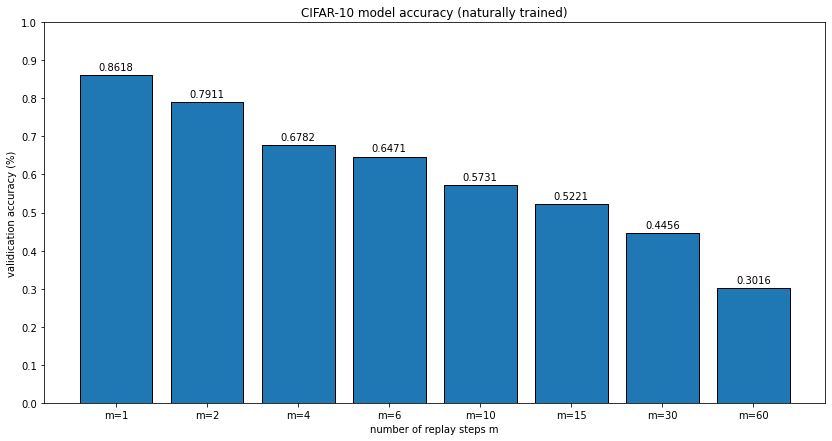

In [20]:
fig,axes=plt.subplots(figsize=(14, 7))
axes.set_title("CIFAR-10 model accuracy (naturally trained)")
axes.set_xlabel("number of replay steps m")
axes.set_ylabel("validication accuracy (%)")
categories = ["m=1", "m=2", "m=4", "m=6", "m=10", "m=15", "m=30", "m=60"] 
output = []

for m in [1,2,4,6,10,15,30,60]:
  #model, meta = load_model("resnet-m="+str(m))
  data = load_data("data-m="+str(m))
  accuracy_m = data["natural"]
  output.append(accuracy_m)
  
axes.set_yticks(np.linspace(0,1,11))
axes.set_ylim(0,1)
b=axes.bar(categories, output, edgecolor="black")
axes.bar_label(b, padding=3)
plt.show()

**COMPARISON WITH DIFFERENT m, DIFFERENT PGD-K and NATURAL TRAIN**

In [27]:
import pandas as pd
train_algs = ['Natural', 'Free m=2', 'Free m=4', 'Free m=6', 'Free m=10', 'Free m=15', 'Free m=30']
natural_data = []
pgd_20 = []
pgd_100 = []
time = []


# NATURAL TRAINING
"""
model, meta = load_model("resnet-natural")
time.append(meta["training_seconds"])
acc_normal, acc_adv = test_pgd_attack(model, k=20)
natural_data.append(acc_normal)
pgd_20.append(acc_adv)
acc_normal, acc_adv = test_pgd_attack(model, k=100)
pgd_100.append(acc_adv)
"""
data = load_data("data-natural")
time.append(data["train_time"])
pgd_20.append(data["pgd20_acc"])
pgd_100.append(data["pgd100_acc"])
natural_data.append(data["natural"])

# FREE TRAINING
for m in [2,4,6,10,15,30]:
  """
  model, meta = load_model("resnet-m="+str(m))
  time.append(meta["training_seconds"])
  acc_normal, acc_adv = test_pgd_attack(model, k=20)
  natural_data.append(acc_normal)
  pgd_20.append(acc_adv)
  acc_normal, acc_adv = test_pgd_attack(model, k=100)
  pgd_100.append(acc_adv)
  """
  meta = load_data("data-m="+str(m))
  time.append(meta["train_time"])
  pgd_20.append(meta["pgd20_acc"])
  pgd_100.append(meta["pgd100_acc"])
  natural_data.append(meta["natural"])

data = {'Natural-Dataset': natural_data,
        'PGD-20':pgd_20,
        'PGD-100':pgd_100,
        'Training-Time (min)':time}
table=pd.DataFrame(data, dtype=float, index= train_algs)
print(table)

           Natural-Dataset  PGD-20  PGD-100  Training-Time (min)
Natural             0.8677  0.0000   0.0000                 27.0
Free m=2            0.7911  0.2680   0.2516                 19.0
Free m=4            0.6782  0.3759   0.3647                 15.0
Free m=6            0.6471  0.3749   0.3698                 14.0
Free m=10           0.5731  0.3560   0.3408                 13.0
Free m=15           0.5221  0.3463   0.3394                 12.0
Free m=30           0.4456  0.2793   0.2733                 11.0


**TODO:** IT IS NEEDED?

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(14,17))
ax2 = axes[0]
ax4 = axes[1]
ax10 = axes[2]
ax30 = axes[3]
#natural = test_loader
#input = list(range(61))
#output = []
i = 0
for m in [2,4,10,30]:
  break
  model, meta = load_model("resnet-m="+str(m))
  acc_normal, acc_adv = test_pgd_attack(model, k=20)
  #axes.plot(input, output[-1], label="trained with m="+str(m))
  input = list(range(60//m))
  axes[i].set_title("CIFAR-10 model accuracy (attacked with PGD20)")
  axes[i].set_xlabel("number of epochs")
  axes[i].set_ylabel("validication accuracy (%)")
  axes[i].plot(input, meta["epoch_accuracies"],label="trained with m="+str(m))
  axes[i].legend(fontsize=10)
  i+=1

